---


Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'LastName_FirstName_T2.3.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### In this tutorial, we will explore Quantization Aware Training! In the first section, we'll create a model for the MNIST Dataset and fine tune it to be Quantization Aware. In the second section, we'll convert this fine-tuned model to a Quantized TFLite model and observe the persistence of accuracy. Finally, in sections 3 and 4 we will compare model performance and model size of the following TFLite models - (i) Baseline TFLite model, (ii) Quantized TFLite model, and (iii) Quantized TFLite model with Quantization Awareness

In [ ]:
! pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.5 MB/s eta 0:00:00


We import the following -


1.    [tensorflow](https://www.tensorflow.org/) - open source library to develop and train ML models
2.   [pathlib](https://docs.python.org/3/library/pathlib.html) - filesystem path
3. [os](https://docs.python.org/3/library/os.html) - perform operating system related tasks



In [ ]:
import pathlib
import os

import tensorflow as tf
from tensorflow import keras

# 1. Fine-tune Baseline Model to become Quantization Aware

### Load Dataset

Here, we will define our baseline model to classify the 10 different digits from the MNIST Dataset. We will load the dataset, split it into train and test datasets, and normalize our data.

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images/255.0 # < YOUR CODE HERE >
test_images =  test_images/255.0 # < YOUR CODE HERE >


11490434/11490434 [==============================] - 1s 0us/step


### Define Baseline Model
The model architecture is defined below. The model takes in (28, 28) greyscale images and applies a convolution and maxpool layer. The final layer has 10 neurons, reflecting the number of classes in our dataset.

We then compile our model.

In [ ]:
# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),                                    # Input layer accepts (28, 28) and converts to (28, 28, 1)
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# baseline model - 'model' (model 1)

---


**Question 1**: Why do we not define a 'softmax' activation function in our final layer of our model?

**Answer:**

---

### Train Baseline Model

We train our model for 1 epoch.

In [ ]:
# Train the digit classification model

model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_split=0.1,
)

1688/1688 [==============================] - 20s 11ms/step - loss: 0.3362 - accuracy: 0.9049 - val_loss: 0.1643 - val_accuracy: 0.9548


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 12)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

### Fine-Tune Baseline Model with Quantization Aware Training

You will apply quantization aware training to the baseline model we created above. This allows the model to learn parameters robust to quantization loss, and also model the accuracy of a quantized model. We will observe this change in the model summary - the layers are now prefixed by "quant". This is done using the `tfmot.quantization.keras.quantize_model()` API. You can read more about this API [here](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/quantization/keras/quantize_model).

***Note1:***  The resulting model is quantization aware but not quantized (e.g. the weights are float32). The sections that follow show how to create a quantized model from the quantization aware one.

***Note2:*** In the [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide.md), you can see how to quantize some layers for model accuracy improvements.


### Import Libraries

We import the following library -


1.   [tensorflow_model_optimization](https://www.tensorflow.org/model_optimization) - suite of tools for optimizing ML models for deployment and execution



In [ ]:
import tensorflow_model_optimization as tfmot

# instantiate API
quantize_model = tfmot.quantization.keras.quantize_model

# create quantization aware model
q_aware_model = quantize_model(model) # <ENTER YOUR CODE HERE>



# quantization aware model - q_aware_model (model 2)

***Hint:*** Use `quantize_model(model)`

We recompile our fine-tuned model!

In [ ]:
# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Summary of Quantization Aware Model!

In [ ]:
# < YOUR CODE HERE >
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_reshape (QuantizeWra  (None, 28, 28, 1)         1         
 pperV2)                                                         
                                                                 
 quant_conv2d (QuantizeWrap  (None, 26, 26, 12)        147       
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 13, 13, 12)        1         
 izeWrapperV2)                                                   
                                                                 
 quant_flatten (QuantizeWra  (None, 2028)              1

### Train Fine-Tuned Model
To demonstrate the power of quantization-aware training, we train our fine-tuned model only on a subset of the training data. We see that the fine-tuned model does very well on the test dataset even though it is trained only on a subset of the dataset. We train for 1 epoch.

In [ ]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

# train our quantization-aware model
q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 1s 377ms/step - loss: 0.1906 - accuracy: 0.9456 - val_loss: 0.1918 - val_accuracy: 0.9400


### Evaluate both models on Test Dataset

We see that for this example, there is minimal to no loss in test accuracy after quantization aware training, compared to the baseline.

In [ ]:
_, baseline_model_accuracy = model.evaluate(test_images, test_labels, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant-Aware test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9472000002861023
Quant-Aware test accuracy: 0.9521999955177307


---


**Question 2**: What is the advantage of Quantization Aware Training?

**Answer:**

---

# 2. Create Quantized Model for TFLite backend

In this section, we will convert our fine-tuned (quantization aware) model to a TFLite model with post-training quantization (Dynamic Range Quantization). After this, we have an actually quantized model with **8-bit precision** values.

In [ ]:
# instantiate converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
quantized_QA_tflite_model = converter.convert() # < YOUR CODE HERE >

tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'quantized_QA_tflite_model.tflite'
tflite_model_file.write_bytes(quantized_QA_tflite_model)

# quantized model with quantization awareness - quantized_QA_tflite_model (model 3)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


24960

***Hint:*** Use the `converter.convert()` method.

---


**Question 3**: How is `tf.lite.TFLiteConverter.from_keras_model()` API different from the `tf.lite.TFLiteConverter.from_saved_model()` API we used in previous tutorials? Can you think of a disadvantage of the former method?

**Answer:**

---

### Observe Persistence of Accuracy from TF to TFLite
We use this Quantized TFLite model to run inference on our test dataset and compare the test accuracy to that of the Quantization Aware TensorFlow model.

We first define a helper function to evaluate our TFLite model's performance on the test dataset. Remember, we have to use an **Interpreter** to run inference of our TFlite model on Colab. The `evaluate_model()` function defined below takes in an instance of the interpreter.

In [ ]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))

    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In the below cell, we instantiate our Interpreter. We evaluate the quantized TFLite model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
# instantiate interpreter
interpreter = tf.lite.Interpreter(model_content=quantized_QA_tflite_model)
interpreter.allocate_tensors()

TFLite_quant_QA_accuracy = evaluate_model(interpreter)


print('Quant TensorFlow test accuracy:', q_aware_model_accuracy)
print('Quant TFLite with QA test accuracy:', TFLite_quant_QA_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TensorFlow test accuracy: 0.9521999955177307
Quant TFLite with QA test accuracy: 0.9522


---


**Question 4**: Why do we allocate tensors to our Interpreter?

**Answer:**

---

#3. Compare TFLite Model Performances

In this section, we will compare the performance of (i) Baseline TFLite model, (ii) Quantized TFLite model, and (iii) Quantized TFLite model with Quantization Awareness on the MNIST Test Dataset.

We already have the test accuracy of the Quantized TFLite model with Quantization Awareness in 'TFLite_QA_test_accuracy' (from Section 2). For the Baseline TFLite model and Quantized TFLite model we convert the baseline TensorFlow model using TFLiteConverter without and with optimization respecively.  

(i) Let's create our Baseline TFLite model! This TFLite model has no Quantization Awareness and no Post-Training Quantization.

In [ ]:
# Create float TFLite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)      # 'model' is our baseline model created in section 1
baseline_tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'baseline_tflite_model.tflite'
tflite_model_file.write_bytes(baseline_tflite_model)

# baseline TFLite model with no quantization awareness and no post-training quantization - baseline_tflite_model (model 4)

84820

Let's evaluate this model on the test dataset and calculate the test accuracy. We instantiate our Interpreter and run inference using our helper function - `evaluate_model()`

In [ ]:
# instantiate interpreter
interpreter = tf.lite.Interpreter(model_content=baseline_tflite_model)
interpreter.allocate_tensors()

TFLite_baseline_accuracy = evaluate_model(interpreter)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




(ii) Let's create our Quantized TFLite model! This TFLite model has Post-Training Quantization but no Quantization Awareness.

In [ ]:
# instantiate converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # < YOUR CODE HERE >

# Convert the model
quantized_tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'quantized_tflite_model.tflite'
tflite_model_file.write_bytes(quantized_tflite_model)


# quantized TFLite model without quantization awareness - quantized_tflite_model (model 5)

24064

***Hint:*** Use `[tf.lite.Optimize.DEFAULT]`

Let's evaluate this model on the test dataset and calculate the test accuracy. We instantiate our Interpreter and run inference using our helper function - `evaluate_model()`

In [ ]:
# TODO : instantiate interpreter and save accuracy to 'TFLite_quant_accuracy'

# instantiate an interpreter object
#interpreter = tf.lite.Interpreter(model_path="path_to_your_tflite_model")
#interpreter.allocate_tensors()

# pass the interpreter object to the function
TFLite_quant_accuracy = evaluate_model(interpreter)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




Let's now compare the test accuracies of the TFLite models!

In [ ]:
print('Baseline TFLite model test accuracy:', TFLite_baseline_accuracy)
print('Quant TFLite model test accuracy:', TFLite_quant_accuracy)
print('Quant TFLite model with QA test accuracy:', TFLite_quant_QA_accuracy)


Baseline TFLite model test accuracy: 0.9472
Quant TFLite model test accuracy: 0.9472
Quant TFLite model with QA test accuracy: 0.9522


# 4. Compare TFLite Model Sizes

In this section we compare the model sizes of (i) Baseline TFLite model, (ii) Quantized TFLite model, and (iii) Quantized TFLite model with Quantization Awareness.

In [ ]:
# Measure sizes of models.
TFLite_baseline_size = os.path.getsize(pathlib.Path("/content/baseline_tflite_model.tflite")) / float(2**20)
TFLite_quant_size = os.path.getsize(pathlib.Path("/content/quantized_tflite_model.tflite")) / float(2**20)
TFLite_quant_QA_size = os.path.getsize(pathlib.Path("/content/quantized_QA_tflite_model.tflite")) / float(2**20)

print("Baseline model in Mb:", TFLite_baseline_size)             # Baseline TFLite model
print("Quantized model in Mb:", TFLite_quant_size)               # Quantized TFLite model
print("Quantized model with QA in Mb:", TFLite_quant_QA_size )   # Quantized TFLite model with Quantization Awareness

Baseline model in Mb: 0.08089065551757812
Quantized model in Mb: 0.02294921875
Quantized model with QA in Mb: 0.0238037109375


We observe that the quantized TFLite models are 4x smaller!

# Visualization of TFLite model Test Accuracies and Sizes

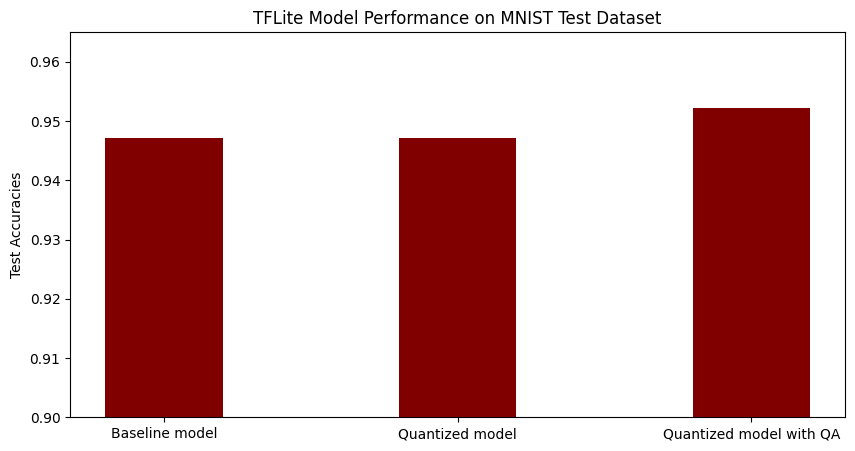

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


accuracies = {'Baseline model':TFLite_baseline_accuracy, 'Quantized model':TFLite_quant_accuracy, 'Quantized model with QA':TFLite_quant_QA_accuracy}
models = list(accuracies.keys())
acc = list(accuracies.values())

fig = plt.figure(figsize = (10, 5))
plt.ylim(0.9, 0.965)

# creating the bar plot
plt.bar(models, acc, color ='maroon',
        width = 0.4)

plt.ylabel("Test Accuracies")
plt.title("TFLite Model Performance on MNIST Test Dataset")
plt.show()

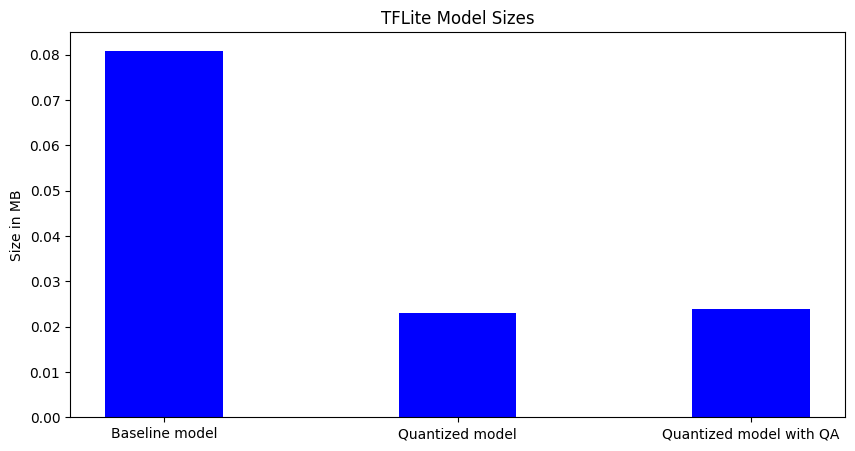

In [ ]:
sizes = {'Baseline model':TFLite_baseline_size, 'Quantized model':TFLite_quant_size, 'Quantized model with QA':TFLite_quant_QA_size}
models = list(sizes.keys())
size = list(sizes.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, size, color ='blue',
        width = 0.4)

plt.ylabel("Size in MB")
plt.title("TFLite Model Sizes")
plt.show()

## Conclusion

In this tutorial, you saw how to create quantization aware models with the TensorFlow Model Optimization Toolkit API and then quantized models for the TFLite backend.You saw a 4x model size compression benefit for a model for MNIST, with minimal accuracy difference.

To see the latency benefits on mobile, try out the TFLite examples [in the TFLite app repository](https://www.tensorflow.org/lite/models).
